In [1]:
import joblib
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#나이브베이즈
from sklearn.naive_bayes import MultinomialNB

#SVM, SVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

#knn
from sklearn.neighbors import KNeighborsClassifier

#DecisionTree
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import linear_kernel


In [2]:
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.impute import SimpleImputer
##
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score , ShuffleSplit
from sklearn import metrics
from sklearn.metrics import roc_curve , roc_auc_score , f1_score , classification_report
## plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

##Model classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

In [4]:
comp_raw=pd.read_excel('./data/comp_ver8_210219.xlsx')
support_raw=pd.read_excel('./data/support_data_ver1_210219.xlsx')

FileNotFoundError: [Errno 2] No such file or directory: './final_data/comp_ver8_210219.xlsx'

In [ ]:
company=comp_raw
support=support_raw

In [75]:
del company['Unnamed: 0']
del support['Unnamed: 0']

In [76]:
print(company.shape)
print(support.shape)

(7202, 21)
(1787, 16)


In [77]:
comp_comp = company['부처명'].tolist()
sup_comp = support['소관부처'].tolist()
comp_list=list(set(comp_comp+sup_comp))

category_dict_encod={}
category_dict_decod={}

for key,name in enumerate(comp_list):
    category_dict_encod.update({name:key})
    category_dict_decod.update({key:name})
print(category_dict_encod)
print(category_dict_decod)

{'중소벤처기업부': 0, '과학기술정보통신부': 1, '교육부': 2, '행정안전부': 3, '농촌진흥청': 4, '산업통상자원부': 5, '문화체육관광부': 6}
{0: '중소벤처기업부', 1: '과학기술정보통신부', 2: '교육부', 3: '행정안전부', 4: '농촌진흥청', 5: '산업통상자원부', 6: '문화체육관광부'}


In [78]:
company['category']=company['부처명'].apply(lambda x:category_dict_encod[x])

tfidf 파라미터 설명 사이트 참고
https://chan-lab.tistory.com/27

In [91]:
X_train, X_test, y_train, y_test = train_test_split(company['all_word'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)

In [92]:
#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['all_word'].tolist()
sup_word=support['all_word'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

svc 파라미터 설명  
C는 '얼마나 많은 데이터 샘플이 다른 클래스에 놓이는 것을 허용하는 정도이다.(soft margin)'
Gamma는 '하나의 데이터 샘플이 영향력을 행사하는 거리이다. 가우시안의 표준편차 역할을 한다고 생각하면 좋다.'
참고로 linear로 하면 파라미터 gamma는 영향이 없게 된다
  
  https://blog.naver.com/twinvest/221587526019


grid_param_svc = [
#{"C" : [1,10,100,1000], "kernel":["linear"]}, # kernel => activation function
{"C" : [1,10,100,1000],"kernel":["sigmoid"], "gamma":[0.001,0.01,0.1,1]}
#{"C" : [1,10,100,1000],"kernel":["rbf"], "gamma":[0.001,0.01,0.1,1]},
#{"C" : [1,10,100,1000],"kernel":["poly"], "gamma":[0.001,0.01,0.1,1]}    
]

In [100]:
pipe_svc=Pipeline([
    ('tfidf', tfidf),
    ('svc', SVC(random_state=42))
])


grid_param_svc={
    'svc__C':[1,10,100,1000],
    'svc__kernel':['sigmoid'],
    'svc__gamma':[0.001,0.01,0.1,1]
    #'svc__max_iter':[500,1000,1500,2000]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_pipe_svc = GridSearchCV(pipe_svc, grid_param_svc, cv=kfold, scoring='accuracy', verbose=1)

grid_pipe_svc.fit(X_train, y_train)
print(grid_pipe_svc.best_params_, grid_pipe_svc.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 78.3min finished


{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'sigmoid'} 0.9376026998321171


In [101]:
pred_svc=grid_pipe_svc.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred_svc)))

예측 정확도 : 0.947


In [102]:
pipe_lisvc=Pipeline([
    ('tfidf', tfidf),
    ('svc', LinearSVC(random_state=42))
])

grid_param_lisvc={
    'svc__C':[1,10,100,1000],
    'svc__penalty':['l1', 'l2'],
    'svc__max_iter':[500,1000,1500,2000]
}

grid_pipe_lisvc = GridSearchCV(pipe_lisvc, param_grid=grid_param_lisvc, cv=kfold, scoring='accuracy', verbose=1)
grid_pipe_lisvc.fit(X_train, y_train)
print(grid_pipe_lisvc.best_params_, grid_pipe_lisvc.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

{'svc__C': 1000, 'svc__max_iter': 500, 'svc__penalty': 'l2'} 0.9401959776612875


In [103]:
pred_lisvc=grid_pipe_lisvc.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred_lisvc)))

예측 정확도 : 0.944


In [106]:
import joblib
joblib.dump(grid_pipe_svc,'./data/model/210220_01_grid_pipe_svc.pkl')
joblib.dump(grid_pipe_lisvc,'./data/model/210220_01_grid_pipe_lisvc.pkl')

['./data/model/210220_01_grid_pipe_lisvc.pkl']

In [108]:
train_col_list = [ '연구_okt', '연구_hannanum', '연구_krwordrank', '연구_kkma', 'krwr_okt', 'krwr_han','all_word']

svc_94_best_params=[]
svc_94_best_score=[]
svc_94_accuracy=[]

lisvc_94_best_params=[]
lisvc_94_best_score=[]
lisvc_94_accuracy=[]


for ind in tqdm_notebook(train_col_list):    
    X_train, X_test, y_train, y_test = train_test_split(company[ind], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)
    ####SVC_94####
    #fit
    grid_pipe_svc.fit(X_train, y_train)
    svc_94_best_params.append(grid_pipe_svc.best_params_)
    svc_94_best_score.append(np.round(grid_pipe_svc.best_score_,3))
    #predict
    pred_svc=grid_pipe_svc.predict(X_test)
    
    
    ####liSVC_94####
    #fit
    grid_pipe_lisvc.fit(X_train, y_train)
    lisvc_94_best_params.append(grid_pipe_lisvc.best_params_)
    lisvc_94_best_score.append(np.round(grid_pipe_lisvc.best_score_,3))
    #predict
    pred_lisvc=grid_pipe_lisvc.predict(X_test)
        
    #정확도
    accuracy_svc=np.round(accuracy_score(pred_svc, y_test),3)
    accuracy_lisvc=np.round(accuracy_score(pred_lisvc, y_test),3)
    
    #리스트에 정확도 저장
    svc_94_accuracy.append(accuracy_svc)
    lisvc_94_accuracy.append(accuracy_lisvc)
    
    print('==============X_train data : ', ind, '==============')
    print('###SVC_94###')
    print("Accuracy Score : {0:.3f}".format(accuracy_svc))
    print('Classification Report')
    print(classification_report(y_test, pred_svc))
    
    print('###liSVC_94###')
    print("Accuracy Score : {0:.3f}".format(accuracy_lisvc))
    print('Classification Report')
    print(classification_report(y_test, pred_lisvc))


#######model Prediction 결과#########
col_name=['svc_94_best_params', 'svc_94_best_score', 'svc_94_accuracy','lisvc_94_best_params',
          'lisvc_94_best_score','lisvc_94_accuracy']
pred_df=pd.DataFrame({col_name[0]:svc_94_best_params,
                      col_name[1]:svc_94_best_score,
                      col_name[2]:svc_94_accuracy,
                      col_name[3]:lisvc_94_best_params,
                      col_name[4]:lisvc_94_best_score,
                      col_name[5]:lisvc_94_accuracy},
                     index=train_col_list)

<ipython-input-108-c7905a4f2151>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm_notebook(train_col_list):


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 39.4min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  연구_okt ==============
###SVC_94###
Accuracy Score : 0.909
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1210
           1       0.88      0.67      0.76       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.86      0.84      0.85       371
           6       1.00      0.22      0.36         9

    accuracy                           0.91      1801
   macro avg       0.67      0.51      0.55      1801
weighted avg       0.91      0.91      0.90      1801

###liSVC_94###
Accuracy Score : 0.904
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1210
           1       0.86      0.65      0.74       189
           2       0.00      0.00      0.00         1
           3    

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 39.7min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  연구_hannanum ==============
###SVC_94###
Accuracy Score : 0.936
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.85      0.73      0.78       189
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50         3
           4       1.00      0.78      0.88        18
           5       0.89      0.89      0.89       371
           6       1.00      0.33      0.50         9

    accuracy                           0.94      1801
   macro avg       0.81      0.58      0.65      1801
weighted avg       0.93      0.94      0.93      1801

###liSVC_94###
Accuracy Score : 0.936
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.85      0.69      0.76       189
           2       0.00      0.00      0.00         1
           

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 30.0min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  연구_krwordrank ==============
###SVC_94###
Accuracy Score : 0.896
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1210
           1       0.81      0.62      0.70       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.83      0.91        18
           5       0.85      0.80      0.82       371
           6       1.00      0.33      0.50         9

    accuracy                           0.90      1801
   macro avg       0.65      0.51      0.55      1801
weighted avg       0.89      0.90      0.89      1801

###liSVC_94###
Accuracy Score : 0.901
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1210
           1       0.80      0.62      0.70       189
           2       0.00      0.00      0.00         1
         

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 39.4min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  연구_kkma ==============
###SVC_94###
Accuracy Score : 0.883
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1210
           1       0.87      0.60      0.71       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.84      0.78      0.81       371
           6       1.00      0.33      0.50         9

    accuracy                           0.88      1801
   macro avg       0.66      0.51      0.56      1801
weighted avg       0.88      0.88      0.88      1801

###liSVC_94###
Accuracy Score : 0.879
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1210
           1       0.86      0.62      0.72       189
           2       0.00      0.00      0.00         1
           3   

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 26.2min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  krwr_okt ==============
###SVC_94###
Accuracy Score : 0.858
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1210
           1       0.78      0.54      0.64       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.80      0.73      0.76       371
           6       1.00      0.22      0.36         9

    accuracy                           0.86      1801
   macro avg       0.64      0.48      0.52      1801
weighted avg       0.85      0.86      0.85      1801

###liSVC_94###
Accuracy Score : 0.862
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1210
           1       0.86      0.50      0.63       189
           2       0.00      0.00      0.00         1
           3  

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 24.1min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  krwr_han ==============
###SVC_94###
Accuracy Score : 0.893
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1210
           1       0.80      0.61      0.69       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.83      0.81      0.82       371
           6       1.00      0.22      0.36         9

    accuracy                           0.89      1801
   macro avg       0.65      0.50      0.54      1801
weighted avg       0.89      0.89      0.89      1801

###liSVC_94###
Accuracy Score : 0.901
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1210
           1       0.80      0.62      0.70       189
           2       0.00      0.00      0.00         1
           3  

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 60.1min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  all_word ==============
###SVC_94###
Accuracy Score : 0.947
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.88      0.76      0.81       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.91      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.56      0.58      1801
weighted avg       0.94      0.95      0.94      1801

###liSVC_94###
Accuracy Score : 0.944
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.88      0.74      0.80       189
           2       0.00      0.00      0.00         1
           3  

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
pred_df

,svc_94_best_params,svc_94_best_score,svc_94_accuracy,lisvc_94_best_params,lisvc_94_best_score,lisvc_94_accuracy
연구_okt,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.890,0.909,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.896,0.904
연구_hannanum,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.927,0.936,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.929,0.936
연구_krwordrank,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.888,0.896,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.894,0.901
연구_kkma,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.876,0.883,"{'svc__C': 100, 'svc__max_iter': 500, 'svc__pe...",0.875,0.879
krwr_okt,"{'svc__C': 1000, 'svc__gamma': 0.01, 'svc__ker...",0.838,0.858,"{'svc__C': 1, 'svc__max_iter': 500, 'svc__pena...",0.841,0.862
krwr_han,"{'svc__C': 1000, 'svc__gamma': 0.01, 'svc__ker...",0.882,0.893,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.886,0.901
all_word,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.938,0.947,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.940,0.944


In [110]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/svc_accuracy.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
pred_df.to_excel(writer)
writer.save()

In [111]:
company.columns

Index(['내역사업명', 'title', '연구목표', '연구내용', '기대효과', '사업명', '부처명', '지역구분',
       '6T관련기술분류', '국가전략기술', '한글키워드', '영문키워드', '과제관리(전문)기관명', '연구', '연구_okt',
       '연구_hannanum', '연구_krwordrank', '연구_kkma', 'krwr_okt', 'krwr_han',
       'all_word', 'category'],
      dtype='object')

In [113]:
# okt + hannnanum + kkma + krwr_han
col_index=[-8,-7,-5,-3]
company['okt_han_krwrhan']=''
for i in tqdm_notebook(range(company.shape[0])):
    comp_word_list=[]
    for j in col_index:
        temp=company.iloc[i,j]
        comp_word_list.append(temp)
        comp_word_list=' '.join(comp_word_list)
        comp_word_list=list(set(comp_word_list.split()))
    company['okt_han_krwrhan'].iloc[i]=' '.join(comp_word_list)

<ipython-input-113-dbbc91bf32ee>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(company.shape[0])):


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [116]:
train_col_list = ['okt_han_krwrhan']

svc_94_best_params=[]
svc_94_best_score=[]
svc_94_accuracy=[]

lisvc_94_best_params=[]
lisvc_94_best_score=[]
lisvc_94_accuracy=[]


for ind in tqdm_notebook(train_col_list):    
    X_train, X_test, y_train, y_test = train_test_split(company[ind], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)
    ####SVC_94####
    #fit
    grid_pipe_svc.fit(X_train, y_train)
    svc_94_best_params.append(grid_pipe_svc.best_params_)
    svc_94_best_score.append(np.round(grid_pipe_svc.best_score_,3))
    #predict
    pred_svc=grid_pipe_svc.predict(X_test)
    
    
    ####liSVC_94####
    #fit
    grid_pipe_lisvc.fit(X_train, y_train)
    lisvc_94_best_params.append(grid_pipe_lisvc.best_params_)
    lisvc_94_best_score.append(np.round(grid_pipe_lisvc.best_score_,3))
    #predict
    pred_lisvc=grid_pipe_lisvc.predict(X_test)
        
    #정확도
    accuracy_svc=np.round(accuracy_score(pred_svc, y_test),3)
    accuracy_lisvc=np.round(accuracy_score(pred_lisvc, y_test),3)
    
    #리스트에 정확도 저장
    svc_94_accuracy.append(accuracy_svc)
    lisvc_94_accuracy.append(accuracy_lisvc)
    
    print('==============X_train data : ', ind, '==============')
    print('###SVC_94###')
    print("Accuracy Score : {0:.3f}".format(accuracy_svc))
    print('Classification Report')
    print(classification_report(y_test, pred_svc))
    
    print('###liSVC_94###')
    print("Accuracy Score : {0:.3f}".format(accuracy_lisvc))
    print('Classification Report')
    print(classification_report(y_test, pred_lisvc))


#######model Prediction 결과#########
col_name=['svc_94_best_params', 'svc_94_best_score', 'svc_94_accuracy','lisvc_94_best_params','lisvc_94_best_score','lisvc_94_accuracy']
pred_df=pd.DataFrame({col_name[0]:svc_94_best_params,
                      col_name[1]:svc_94_best_score,
                      col_name[2]:svc_94_accuracy,
                      col_name[3]:lisvc_94_best_params,
                      col_name[4]:lisvc_94_best_score,
                      col_name[5]:lisvc_94_accuracy},
                     index=train_col_list)

<ipython-input-116-832ad7afaf34>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm_notebook(train_col_list):


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 61.6min finished


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 233, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 965, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\U

==============X_train data :  okt_han_krwrhan ==============
###SVC_94###
Accuracy Score : 0.951
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.90      0.78      0.83       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.92      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.56      0.59      1801
weighted avg       0.95      0.95      0.95      1801

###liSVC_94###
Accuracy Score : 0.952
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.91      0.76      0.82       189
           2       0.00      0.00      0.00         1
       

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [208]:
scores_df = pd.DataFrame(grid_pipe_svc.cv_results_)
scores_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,25.555447,0.320774,5.519638,0.050525,1,0.001,sigmoid,"{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kerne...",0.672525,0.679630,0.666667,0.656481,0.682407,0.671542,0.009328,14
1,34.651310,0.296919,6.740969,0.028808,1,0.01,sigmoid,"{'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel...",0.672525,0.679630,0.666667,0.656481,0.682407,0.671542,0.009328,14
2,39.658326,0.481215,7.066900,0.048974,1,0.1,sigmoid,"{'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel'...",0.677151,0.681481,0.674074,0.664815,0.689815,0.677467,0.008250,11
3,33.525930,0.514460,6.237318,0.034607,1,1,sigmoid,"{'svc__C': 1, 'svc__gamma': 1, 'svc__kernel': ...",0.918594,0.938889,0.912037,0.916667,0.921296,0.921497,0.009206,10
4,34.562159,0.285657,6.728003,0.048296,10,0.001,sigmoid,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...",0.672525,0.679630,0.666667,0.656481,0.682407,0.671542,0.009328,14
5,40.003004,0.575882,7.059326,0.054950,10,0.01,sigmoid,"{'svc__C': 10, 'svc__gamma': 0.01, 'svc__kerne...",0.677151,0.681481,0.674074,0.664815,0.689815,0.677467,0.008250,11
6,41.090100,2.312168,7.261773,0.720529,10,0.1,sigmoid,"{'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel...",0.924144,0.943519,0.912963,0.917593,0.921296,0.923903,0.010499,7
7,32.425473,0.615455,6.007333,0.092423,10,1,sigmoid,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.936170,0.949074,0.925000,0.928704,0.937963,0.935382,0.008332,1
8,41.518152,0.901466,7.320024,0.247253,100,0.001,sigmoid,"{'svc__C': 100, 'svc__gamma': 0.001, 'svc__ker...",0.677151,0.681481,0.674074,0.664815,0.689815,0.677467,0.008250,11
9,42.802319,1.676831,7.217102,0.234931,100,0.01,sigmoid,"{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kern...",0.924144,0.943519,0.912963,0.917593,0.921296,0.923903,0.010499,7


In [130]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/svc_accuracy_add.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
pred_df.to_excel(writer)
writer.save()

In [ ]:
writer = pd.ExcelWriter('./data/model/svc_accuracy_add.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
pred_df.to_excel(writer)
writer.save()

In [190]:
#!pip install yellowbrick

In [202]:
from yellowbrick.classifier import ROCAUC

X_train, X_test, y_train, y_test = train_test_split(company['all_word'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)
 #X_train 벡터화
temp =X_train.tolist()
X_train_tfidf = tfidf.transform(temp)
print(X_train_tfidf.shape)

#X_test 벡터화
temp =X_test.tolist()
X_test_tfidf = tfidf.transform(temp)
print(X_test_tfidf.shape)

(5401, 33248)
(1801, 33248)


[LibLinear]

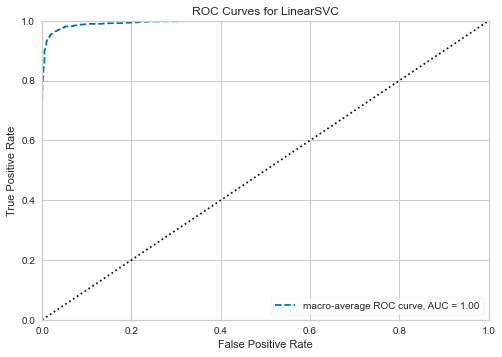

<AxesSubplot:title={'center':'ROC Curves for LinearSVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [206]:
clf = LinearSVC(C=1000,max_iter=500, penalty='l2',verbose=True)

visualizer = ROCAUC(clf, classes=[0,1,2,3,4,5,6], micro=False, macro=True, per_class=False)
visualizer.fit(X_train_tfidf, y_train)
visualizer.score(X_test_tfidf, y_test)
visualizer.show()

In [201]:
clf = SVC(kernel='linear',C=100,gamma=0.01, verbose=True)
visualizer = ROCAUC(clf, classes=[0,1,2,3,4,5,6], micro=False, macro=True, per_class=False)
visualizer.fit(X_train_tfidf, y_train)
visualizer.score(X_train_tfidf, y_train)
visualizer.show()

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [128]:
df

,svc_94_best_params,svc_94_best_score,svc_94_accuracy,lisvc_94_best_params,lisvc_94_best_score,lisvc_94_accuracy
Unnamed: 0,,,,,,
연구_okt,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.890,0.909,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.896,0.904
연구_hannanum,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.927,0.936,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.929,0.936
연구_krwordrank,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.888,0.896,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.894,0.901
연구_kkma,"{'svc__C': 100, 'svc__gamma': 0.1, 'svc__kerne...",0.876,0.883,"{'svc__C': 100, 'svc__max_iter': 500, 'svc__pe...",0.875,0.879
krwr_okt,"{'svc__C': 1000, 'svc__gamma': 0.01, 'svc__ker...",0.838,0.858,"{'svc__C': 1, 'svc__max_iter': 500, 'svc__pena...",0.841,0.862
krwr_han,"{'svc__C': 1000, 'svc__gamma': 0.01, 'svc__ker...",0.882,0.893,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.886,0.901
all_word,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.938,0.947,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.940,0.944


In [131]:
df=pd.read_excel('./data/model/svc_accuracy.xlsx')
dff=pd.read_excel('./data/model/svc_accuracy_add.xlsx')

In [143]:
df_table = pd.concat([df,dff], axis=0)

In [145]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/svc_accuracy_ver2.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
df_table.to_excel(writer)
writer.save()

In [ ]:
'''{'svc__C': 100, 'svc__kernel': 'linear'} 0.9289029362387364'''
pred=grid_cv_pipe.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred)))

In [ ]:
'''{'svc__C': 100, 'svc__kernel': 'sigmoid'} 0.9348274916915065'''
pred=grid_cv_pipe.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred)))

In [ ]:
'''{'svc__C': 10, 'svc__kernel': 'rbf'} 0.8835407887073012'''
pred=grid_cv_pipe.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred)))
sorted(grid_cv_pipe.cv_results_.keys())

In [ ]:
pipe_rf = Pipeline([('tfidf', tfidf),
                    ('rf', RandomForestClassifier(random_state=42))])

grid_rf={
    'rf__criterion':['gini']
}

grid_cv_rf = GridSearchCV(pipe_rf, param_grid=grid_rf, scoring='accuracy', verbose=1)
grid_cv_rf.fit(X_train, y_train)
print(grid_cv_rf.best_params_, grid_cv_rf.best_score_)

In [ ]:
'''0.8885397608524344'''
pred=grid_cv_rf.predict(X_test)
print("예측 정확도 : {0:.3f}".format(accuracy_score(y_test,pred)))

# pipeline (randomforest, knn, svm(sigmoid), LinearSVC)
tfidf.fit(사업개요 all_word + 과제 all_word)


In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import StandardScaler  ,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.impute import SimpleImputer
##
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score , ShuffleSplit
from sklearn import metrics
from sklearn.metrics import roc_curve , roc_auc_score , f1_score , classification_report, recall_score, precision_score
from sklearn.metrics import *
## plot
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets

##Model classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import GradientBoostingClassifier as GBM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier 


In [210]:
X_train, X_test, y_train, y_test = train_test_split(company['all_word'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)


#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['all_word'].tolist()
sup_word=support['all_word'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [222]:
pipe_svc=Pipeline([('tfidf', tfidf),
                   ('clf', SVC(random_state=42))])

pipe_lisvc=Pipeline([('tfidf', tfidf),
                     ('clf', LinearSVC(random_state=42))])

pipe_rf = Pipeline([('tfidf', tfidf),
                    ('clf', RandomForestClassifier(random_state=42))])

pipe_knn = Pipeline([('tfidf', tfidf),
                    ('clf', KNeighborsClassifier())])


#GridSearch 파라미터 설정
grid_param_svc = {
    'clf__C':[10],
    'clf__kernel':['linear','sigmoid'],
    'clf__gamma':[1]
}


grid_param_lisvc={
    'clf__C':[1000],
    'clf__penalty':['l2'],
    'clf__max_iter':[500]
}

grid_param_rf={
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_leaf_nodes': [16, 64, 128, 256],
    'clf__max_depth': np.linspace(1, 32, 2),
    'clf__n_estimators': np.arange(100, 1000, 300),
    'clf__oob_score':[True]
}


grid_param_knn={
    'clf__n_neighbors':[1,3,5],
    'clf__algorithm':['auto'],
    'clf__weights':['uniform', 'distance'],
    'clf__leaf_size':[1, 2, 3, 4, 5, 10]
}

pipe = [pipe_svc, pipe_lisvc, pipe_rf , pipe_knn]
params = [grid_param_svc, grid_param_lisvc, grid_param_rf, grid_param_knn]

scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}

grid_dict = {0: 'SVC_sigmoid', 
             1: 'Linear SVC', 
             3: 'Random Forest',
             4: 'KNNClassifier'}

accuracy_list=[]
best_params_list=[]
best_score_list=[]



In [223]:

# create the Kfold object
kfold = KFold(n_splits=5, random_state=42)
cv_df=pd.DataFrame()


for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, cv=kfold, scoring='accuracy', n_jobs=-1)
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
    accuracy_list.append(np.round(accuracy_score(y_pred, y_test),3))
    best_params_list.append(search.best_params_)
    best_score_list.append(search.best_score_)
    
    temp_df=pd.DataFrame(search.cv_results_)
    cv_df=pd.concat([cv_df,temp_df], axis=0)
    
    print('###%s###'%model)    
    print("Accuracy Score : {0:.3f}".format(accuracy_score(y_pred, y_test)))
    print('Classification Report')
    print(classification_report(y_test, y_pred))


    
#######model Prediction 결과#########
pipe2_df=pd.DataFrame({'accuracy':accuracy_list,
                      'best_params':best_params_list,
                      'best_score':best_score_list},index=grid_dict.values())
    


###Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', SVC(random_state=42))])###
Accuracy Score : 0.947
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.88      0.76      0.81       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.91      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.56      0.58      1801
weighted avg       0.94      0.95      0.94      1801



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


###Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', LinearSVC(random_state=42))])###
Accuracy Score : 0.944
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.88      0.74      0.80       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.90      0.92      0.91       371
           6       1.00      0.33      0.50         9

    accuracy                           0.94      1801
   macro avg       0.68      0.57      0.60      1801
weighted avg       0.94      0.94      0.94      1801

###Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
         

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('clf', KNeighborsClassifier())])###
Accuracy Score : 0.836
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1210
           1       0.79      0.50      0.61       189
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50         3
           4       0.89      0.94      0.92        18
           5       0.74      0.69      0.71       371
           6       1.00      0.44      0.62         9

    accuracy                           0.84      1801
   macro avg       0.76      0.55      0.61      1801
weighted avg       0.83      0.84      0.83      1801



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [226]:
pipe2_df

,accuracy,best_params,best_score
SVC_sigmoid,0.947,"{'clf__C': 10, 'clf__gamma': 1, 'clf__kernel':...",0.933717
Linear SVC,0.944,"{'clf__C': 1000, 'clf__max_iter': 500, 'clf__p...",0.932977
Random Forest,0.848,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.851138
KNNClassifier,0.836,"{'clf__algorithm': 'auto', 'clf__leaf_size': 1...",0.820590


4가지 알고리즘 돌려서 가장 성능 좋은 알고리즘 찾기  
tfidf : 사업개요 all_word + 과제 all_word

In [227]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/all_word_pipeline.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
pipe2_df.to_excel(writer)
writer.save()

------

svc, svm 알고리즘 성능이 가장 좋음  
tfidif 경우에 따라 성능 측정하기

In [228]:
company.columns

Index(['내역사업명', 'title', '연구목표', '연구내용', '기대효과', '사업명', '부처명', '지역구분',
       '6T관련기술분류', '국가전략기술', '한글키워드', '영문키워드', '과제관리(전문)기관명', '연구', '연구_okt',
       '연구_hannanum', '연구_krwordrank', '연구_kkma', 'krwr_okt', 'krwr_han',
       'all_word', 'category', 'okt_han_krwrhan', 'han_krwrhan'],
      dtype='object')

In [229]:
# okt_han_krwrhan 이름에 kkma가 안들어가서 애매하므로 okt_han_kkma_krwrhan로 변경
company.rename(columns={'okt_han_krwrhan':'okt_han_kkma_krwrhan'}, inplace=True)

In [249]:
col_ind_dict = dict(enumerate(company.columns))
print(col_ind_dict)

{0: '내역사업명', 1: 'title', 2: '연구목표', 3: '연구내용', 4: '기대효과', 5: '사업명', 6: '부처명', 7: '지역구분', 8: '6T관련기술분류', 9: '국가전략기술', 10: '한글키워드', 11: '영문키워드', 12: '과제관리(전문)기관명', 13: '연구', 14: '연구_okt', 15: '연구_hannanum', 16: '연구_krwordrank', 17: '연구_kkma', 18: 'krwr_okt', 19: 'krwr_han', 20: 'all_word', 21: 'category', 22: 'okt_han_kkma_krwrhan', 23: 'han_krwrhan', 24: 'okt_han_kkma'}


In [274]:
col_ind_dict = dict(enumerate(company.columns))

def make_new_col(*col_index, col_name):
    col_index_list=[]
    for t in col_index:
        col_index_list.append(t)
        if t == col_index[-1]:
            print(col_ind_dict[t],'=============')
        else:
            print('=============',col_ind_dict[t], end=' + ')
             
    company[col_name]=''
    for i in tqdm_notebook(range(company.shape[0])):
        comp_word_list=[]
        for j in col_index_list:
            temp=company.iloc[i,j]
            comp_word_list.append(temp)
            comp_word_list=' '.join(comp_word_list)
            comp_word_list=list(set(comp_word_list.split()))
        company[col_name].iloc[i]=' '.join(comp_word_list)
    print('=============컬럼추가 완료=============')

In [275]:
'''
14: '연구_okt', 15: '연구_hannanum',
16: '연구_krwordrank', 17: '연구_kkma',
18: 'krwr_okt', 19: 'krwr_han'
'''
#okt_han_kkma
make_new_col(14,15,17,col_name='okt_han_kkma')

#okt+han+kkma+krwr_han 이미 추가되어 있음

#krwr_okt + krwr_han
make_new_col(18,19,col_name='krwrokt_krwrhan')

#okt + hannanum
make_new_col(14,15,col_name='okt_hannanum')

#okt + hannanum + krwr_han
make_new_col(14,15,19,col_name='okt_han_krwrhan')






============= 연구_okt + ============= 연구_hannanum + 연구_kkma =============


<ipython-input-274-07c1fe892f05>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(company.shape[0])):


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)



=============컬럼추가 완료=============
============= krwr_okt + krwr_han =============



=============컬럼추가 완료=============
============= 연구_okt + 연구_hannanum =============



=============컬럼추가 완료=============
============= 연구_okt + ============= 연구_hannanum + krwr_han =============



=============컬럼추가 완료=============


In [276]:
company.head()

,내역사업명,title,연구목표,연구내용,기대효과,사업명,부처명,지역구분,6T관련기술분류,국가전략기술,...,연구_kkma,krwr_okt,krwr_han,all_word,category,okt_han_kkma_krwrhan,okt_han_kkma,krwrokt_krwrhan,okt_hannanum,okt_han_krwrhan
0,2020년도 창업성장기술개발사업 전략형 창업과제 BIG3 제1차 시행계획 공고,전략형창업과제,적용 모터 분석 구동부 설계 궤도 설계 차체설계 및 제작 샤시설계 및 제작 전장 시...,적용 모터 분석 전기자동차 적용 모터 분석 및 최적화 모델 검색 감속기 적용 감속비...,프로토 타입 제작 완료를 통한제품 성능평가 제품 설계 완성 및 조립도 완성 샤시와 ...,창업성장기술개발 R D,중소벤처기업부,경기,위의 미래유망신기술 6T 103개 세분류에 속하지 않는 기타 연구,스마트 자동차 기술,...,감속기 big 다목적 프로그래밍 pto ux smart 모델링 multipurpos...,와이어 로봇 컨트롤러 주행 인터페이스 프로그래밍 공장 카티아 충전 ui multip...,현가장치 로봇 컨트롤러 물리적 용접포인트 4ir 인터페이스 외부충격 프로그래밍 인허...,작동부 동력전달 용접 4ir 속하지 생산성 하우징 cell 차연도 설계도서 와이어 ...,0,공고프로토 모터부 자동차 주행 구동부 하네스 계산한 차연도 car 용접 big 미래...,자동차 공고프로토 모터부 구동부 주행 하네스 car 용접 big 미래유망신기술 시스...,자동차 ui 컨트롤러 성능평가 로봇 주행 대비한 구동부 와이어링 하네스 multip...,자동차 공고프로토 모터부 주행 구동부 하네스 car 용접 big 미래유망신기술 베터...,자동차 공고프로토 모터부 구동부 주행 하네스 car 용접 big 미래유망신기술 카티...
1,2019년도 창업성장기술개발사업 혁신형 창업과제 민간투자연계형 제1차 시행계획 공고,개발자 없이 O2O 플랫폼 서비스를 창업할 수 있는 클라우드 인프라 솔루션 상용화 개발,사용자 주문 조합형 백엔드 모듈 개발 각 사용자 니즈에 따른 맞춤 DB 추가 기술 ...,사용자 주문 조합형 백엔드 모듈 개발 서비스 주문 방식에 따른 데이터베이스 설계 D...,O2O 플랫폼 서비스 아이디어가 있는데 개발자를 구하기 어렵고 자본도 부족한 창업자...,창업성장기술개발 R D,중소벤처기업부,광주,기타 정보처리시스템 및 S W 기술,시스템 SW 운영 및 기반 기술,...,컴포넌트 create script 엔드 치환 동적 백오피스 클라우드 소프트웨어 ap...,소프트웨어 object 멀티 element DB delete sw 클라우드 css ...,작업2019년 element 소프트웨어 object 멀티 역치환 생성 delete ...,역치환 CSS 클라우드 수정하기 웹페이지 멀티 형태로 혼용하여 생성 json ui빌...,0,delete 방식들 민간투자연계형 작성된 table cloud uiux 구성한 다기...,delete 방식들 민간투자연계형 table cloud uiux 다기 구성한 obj...,delete script ui sql update 민간투자연계형 orm soluti...,delete 방식들 민간투자연계형 table cloud uiux 다기 구성한 obj...,delete 방식들 민간투자연계형 table cloud uiux 다기 구성한 obj...
2,2020년도 창업성장기술개발사업 디딤돌 창업과제 첫걸음 제1차 시행계획 수정 공고,디딤돌창업과제 전자감응자가기동 표적기,현 자동화 사격훈련 장비 시스템 현 자동화 실탄사격장은 사수가 사격 후 표적기에 위...,현재 주관연구기관은 특허기반으로 개발 한 무선통신방식의 PCB보드를 기반으 로 하는...,선행연구과제 실증을 통해 개발 완료 된 자동화 사격장비 기술을 바탕으로 Ultras...,창업성장기술개발 R D,중소벤처기업부,세종,기타 정보기술,국방 스마트 플랫폼 및 무인화 지능화 기술,...,tool 사격 기동 통제 bar 경찰 모듈 계열 방위 근간 양궁 object 탄환 ...,이미지 와이어 tool 모양 상대 양궁 fusion ultrasonic object...,와이어리스자가기동 전처리 이미지 가시화용 tool 모양 양궁 fusion ultra...,표적기현 목표물의 진보시키는 bar 스포츠 표적크기 연구과제 초음파모듈센서 it 가...,0,판매가 렌더링 표적시스템 이미지프로세싱 실증을 가시 특허기반 감응 사격장 이루도록 ...,판매가 렌더링 표적시스템 이미지프로세싱 가시 특허기반 감응 사격장 object 수가...,렌더링 가시 특허기반 object 저렴 bar 카메라 초음파 플랫폼 센서 모양 이미...,판매가 렌더링 표적시스템 이미지프로세싱 가시 특허기반 감응 사격장 object 센서...,판매가 렌더링 표적시스템 이미지프로세싱 가시 특허기반 감응 사격장 object 센서...
3,2019년도 창업성장기술개발사업 디딤돌 창업과제 제3차 시행계획 공고,디딤돌 창업과제,의료 재생의학용 3D 바이오 프린팅 지지체 제작을 위해 150 m 해상도로 프린팅이...,돈피 유래 아텔로콜라겐 추출 정제 공정 최적화 및 수율 개선 의료 재생용 아텔로콜라...,본 연구를 통해 개발하고자 하는 의료 재생용 3D 바이오 프린팅용 바이오 잉크의 최...,창업성장기술개발 R D,중소벤처기업부,경기,생체조직 재생기술,바이오 및 생체공학 기반 인공장기 기술,...,bioink 의료 구조체 growth 속도 첨가 세계적 질환 거부 연구소 명시 수율...,이식 성형 장기 kda 아틸 치료 세포 재생 기성 발전 세계 생물학 axis pri...,이식 세계적 kda 아틸 재현성 치료 세포 재생 물리학적 기성 발전 3D 창업성장기...,240 가능성 의료적 고려하여 정제 직선 제품개발 해상도bioink 더불어 유래 최...,0,아틸 재생의학 원활 다양성 재생용 의약품 240 필요한 세포 인공장기 인공 기술바이...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 인공장기 인공 기술바이오잉크 ...,아틸 다양성 원활 의약품 240 세포 인공장기 인공 다품종 개개인 차별화 명시 치료...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 인공장기 인공 기술바이오잉크 ...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 인공장기 인공 기술바이오잉크 ...
4,2019년도 창업성장기술개발사업 디딤돌 창업과제 제3차 시행계획 공고,디딤돌 창업과제,의료 재생의학용 3D 바이오 프린팅 지지체 제작을 위해 150 m 해상도로 프린팅이...,돈피 유래 아텔로콜라겐 추출 정제 공정 최적화 및 수율 개선 의료 재생용 아텔로콜라...,본 연구를 통해 개발하고자 하는 의료 재생용 3D 바이오 프린팅용 바이오 잉크의 최...,창업성장기술개발 R D,중소벤처기업부,강원,위의 미래유망신기술 6T 103개 세분류에 속하지 않는 기타 연구,재난현장 소방구조 장비 시스템 기술,...,스키 방재 의료 구조체 설비 growth 속도 첨가 세계적 질환 skipping 거...,이식 성형 kda 아틸 소방방 치료 재생 세포 건축 기성 발전 prevention ...,이식 세계적 kda 아틸 재현성 치료 세포 재생 물리학적 기성 발전 preventi...,240 가능성 의료적 고려하여 정제 직선 제품개발 더불어 유래 스키핑현상 현상 최적...,0,아틸 재생의학 원활 다양성 재생용 의약품 240 필요한 세포 다품종 개개인 스키 조...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 다품종 개개인 스키 조직재생용...,아틸 다양성 원활 의약품 240 세포 다품종 개개인 스키 차별화 명시 치료 prev...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 다품종 개개인 스키 조직재생용...,아틸 재생의학 원활 다양성 재생용 의약품 240 세포 다품종 개개인 스키 조직재생용...


In [306]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/company_all_token_210222.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
company.to_excel(writer)
writer.save()

In [292]:
pipe_svc=Pipeline([
    ('tfidf', tfidf),
    ('svc', SVC(random_state=42))
])

grid_param_svc={
    'svc__C':[1,10,100,1000],
    'svc__kernel':['sigmoid', 'linear'],
    'svc__gamma':[0.001,0.01,0.1,1]
}

pipe_lisvc=Pipeline([
    ('tfidf', tfidf),
    ('svc', LinearSVC(random_state=42))
])

grid_param_lisvc={
    'svc__C':[1,10,100,1000],
    'svc__penalty':['l1', 'l2'],
    'svc__max_iter':[500,1000,1500,2000]
}

pipe=[pipe_svc,pipe_lisvc]
params=[grid_param_svc,grid_param_lisvc]


In [294]:
train_col_list = ['okt_han_kkma', 'okt_han_kkma_krwrhan', '연구_krwordrank', 'krwrokt_krwrhan', 'okt_hannanum', 'okt_han_krwrhan','all_word']

svc_94_best_params=[]
svc_94_best_score=[]
svc_94_accuracy=[]

lisvc_94_best_params=[]
lisvc_94_best_score=[]
lisvc_94_accuracy=[]


kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for ind in tqdm_notebook(train_col_list): 
    print('#############%s 컬럼#############'%ind)
    X_train, X_test, y_train, y_test = train_test_split(company[ind], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)
    
    for idx , (param , model) in enumerate(zip(params , pipe)) :
        print('<model>')
        print(model)
        search =GridSearchCV(model, param, cv=kfold, scoring='accuracy', verbose=1)
        search.fit(X_train, y_train)
        pred_y = search.predict(X_test)
        accuracy=accuracy_score(pred_y, y_test)
        
        if model==pipe[0]:
            svc_94_best_params.append(search.best_params_)
            svc_94_best_score.append(np.round(search.best_score_,3))
            svc_94_accuracy.append(np.round(accuracy,3))

            
        if model==pipe[1]:
            lisvc_94_best_params.append(search.best_params_)
            lisvc_94_best_score.append(np.round(search.best_score_,3))
            lisvc_94_accuracy.append(np.round(accuracy,3))
            
        print("Accuracy Score : {0:.3f}".format(accuracy))
        print(classification_report(y_test, pred_y))
        print('=====알고리즘 완료=====')

col_name=['svc_94_best_params', 'svc_94_best_score', 'svc_94_accuracy','lisvc_94_best_params','lisvc_94_best_score','lisvc_94_accuracy']
pred_df=pd.DataFrame({col_name[0]:svc_94_best_params,
                      col_name[1]:svc_94_best_score,
                      col_name[2]:svc_94_accuracy,
                      col_name[3]:lisvc_94_best_params,
                      col_name[4]:lisvc_94_best_score,
                      col_name[5]:lisvc_94_accuracy},
                     index=train_col_list)

<ipython-input-294-d3cead370d29>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ind in tqdm_notebook(train_col_list):


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


#############okt_han_kkma 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 120.3min finished


Accuracy Score : 0.954
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.89      0.83      0.85       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.94      0.97        18
           5       0.93      0.93      0.93       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.56      0.59      1801
weighted avg       0.95      0.95      0.95      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.955
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.90      0.80      0.85       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.93      0.93      0.93       371
           6       1.00      0.33      0.50         9

    accuracy                           0.96      1801
   macro avg       0.69      0.58      0.61      1801
weighted avg       0.95      0.96      0.95      1801

=====알고리즘 완료=====
#############okt_han_kkma_krwrhan 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 125.2min finished


Accuracy Score : 0.951
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.90      0.78      0.83       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.92      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.56      0.59      1801
weighted avg       0.95      0.95      0.95      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.952
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.91      0.76      0.82       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      1.00      1.00        18
           5       0.92      0.94      0.93       371
           6       1.00      0.33      0.50         9

    accuracy                           0.95      1801
   macro avg       0.68      0.57      0.60      1801
weighted avg       0.95      0.95      0.95      1801

=====알고리즘 완료=====
#############연구_krwordrank 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 62.6min finished


Accuracy Score : 0.896
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1210
           1       0.81      0.62      0.70       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.83      0.91        18
           5       0.85      0.80      0.82       371
           6       1.00      0.33      0.50         9

    accuracy                           0.90      1801
   macro avg       0.65      0.51      0.55      1801
weighted avg       0.89      0.90      0.89      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.901
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1210
           1       0.80      0.62      0.70       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.85      0.81      0.83       371
           6       1.00      0.33      0.50         9

    accuracy                           0.90      1801
   macro avg       0.65      0.52      0.56      1801
weighted avg       0.90      0.90      0.90      1801

=====알고리즘 완료=====
#############krwrokt_krwrhan 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 64.2min finished


Accuracy Score : 0.900
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1210
           1       0.85      0.63      0.73       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.78      0.88        18
           5       0.86      0.81      0.83       371
           6       1.00      0.22      0.36         9

    accuracy                           0.90      1801
   macro avg       0.66      0.49      0.53      1801
weighted avg       0.90      0.90      0.89      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.911
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1210
           1       0.85      0.66      0.74       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.89      0.94        18
           5       0.87      0.84      0.85       371
           6       1.00      0.33      0.50         9

    accuracy                           0.91      1801
   macro avg       0.66      0.53      0.57      1801
weighted avg       0.91      0.91      0.91      1801

=====알고리즘 완료=====
#############okt_hannanum 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 112.7min finished


Accuracy Score : 0.947
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.88      0.77      0.82       189
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50         3
           4       1.00      0.94      0.97        18
           5       0.91      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.82      0.60      0.65      1801
weighted avg       0.95      0.95      0.94      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.948
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.89      0.76      0.82       189
           2       0.00      0.00      0.00         1
           3       1.00      0.33      0.50         3
           4       1.00      1.00      1.00        18
           5       0.91      0.92      0.92       371
           6       1.00      0.33      0.50         9

    accuracy                           0.95      1801
   macro avg       0.82      0.62      0.67      1801
weighted avg       0.95      0.95      0.95      1801

=====알고리즘 완료=====
#############okt_han_krwrhan 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 114.1min finished


Accuracy Score : 0.947
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1210
           1       0.88      0.76      0.82       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.94      0.97        18
           5       0.91      0.92      0.92       371
           6       1.00      0.22      0.36         9

    accuracy                           0.95      1801
   macro avg       0.68      0.55      0.58      1801
weighted avg       0.94      0.95      0.94      1801

=====알고리즘 완료=====
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', LinearSVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\lib

Accuracy Score : 0.951
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1210
           1       0.90      0.77      0.83       189
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       1.00      0.94      0.97        18
           5       0.92      0.93      0.92       371
           6       1.00      0.33      0.50         9

    accuracy                           0.95      1801
   macro avg       0.68      0.57      0.60      1801
weighted avg       0.95      0.95      0.95      1801

=====알고리즘 완료=====
#############all_word 컬럼#############
<model>
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 2),
                                 sublinear_tf=True)),
                ('svc', SVC(random_state=42))])
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [301]:
train_col_list = ['okt_han_kkma', 'okt_han_kkma_krwrhan', '연구_krwordrank', 'krwrokt_krwrhan', 'okt_hannanum', 'okt_han_krwrhan']

col_name=['svc_94_best_params', 'svc_94_best_score', 'svc_94_accuracy','lisvc_94_best_params','lisvc_94_best_score','lisvc_94_accuracy']
pred_df_100=pd.DataFrame({col_name[0]:svc_94_best_params,
                      col_name[1]:svc_94_best_score,
                      col_name[2]:svc_94_accuracy,
                      col_name[3]:lisvc_94_best_params,
                      col_name[4]:lisvc_94_best_score,
                      col_name[5]:lisvc_94_accuracy},
                     index=train_col_list)

In [302]:
pred_df_100

,svc_94_best_params,svc_94_best_score,svc_94_accuracy,lisvc_94_best_params,lisvc_94_best_score,lisvc_94_accuracy
okt_han_kkma,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.941,0.954,"{'svc__C': 100, 'svc__max_iter': 500, 'svc__pe...",0.940,0.955
okt_han_kkma_krwrhan,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.935,0.951,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.936,0.952
연구_krwordrank,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...",0.888,0.896,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.894,0.901
krwrokt_krwrhan,"{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kern...",0.894,0.900,"{'svc__C': 10, 'svc__max_iter': 500, 'svc__pen...",0.896,0.911
okt_hannanum,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.941,0.947,"{'svc__C': 1000, 'svc__max_iter': 500, 'svc__p...",0.941,0.948
okt_han_krwrhan,"{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel':...",0.941,0.947,"{'svc__C': 100, 'svc__max_iter': 500, 'svc__pe...",0.941,0.951


In [303]:
#엑셀파일 저장
writer = pd.ExcelWriter('./data/model/svc_accuracy_ver2_add.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
pred_df_100.to_excel(writer)
writer.save()

나이브 베이즈 추가

In [5]:
comp_raw=pd.read_excel('./final_data/company_final_new_210222.xlsx')
support_raw=pd.read_excel('./final_data/support_final_new_210222.xlsx')

company=comp_raw
support=support_raw

In [5]:
X_train, X_test, y_train, y_test = train_test_split(company['all_word'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)


#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['all_word'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [6]:
#X_train 벡터화
temp =X_train.tolist()
X_train_tfidf = tfidf.transform(temp)
print(X_train_tfidf.shape)

#X_test 벡터화
temp =X_test.tolist()
X_test_tfidf = tfidf.transform(temp)
print(X_test_tfidf.shape)

(5401, 43386)
(1801, 43386)


In [8]:
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

nb = MultinomialNB()
param_grid = [{'alpha' : np.linspace(0.01,1,100)}]
gs = GridSearchCV(estimator=nb, param_grid=param_grid, scoring='accuracy')
gs.fit(X_train_tfidf,y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=MultinomialNB(),
             param_grid=[{'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])}],
             scoring='accuracy')

In [9]:
print(gs.best_score_)
print(gs.best_params_)

0.8505814232363724
{'alpha': 0.03}


In [11]:
predictions = gs.predict(X_test_tfidf)

print('정답률:', accuracy_score(predictions, y_test))
print(classification_report(y_test, predictions))

정답률: 0.855635757912271
              precision    recall  f1-score   support

           0       0.84      0.43      0.57       189
           1       0.00      0.00      0.00         3
           2       0.92      0.67      0.77        18
           3       1.00      0.11      0.20         9
           4       0.86      0.97      0.91      1210
           5       0.83      0.74      0.78       371
           6       0.00      0.00      0.00         1

    accuracy                           0.86      1801
   macro avg       0.64      0.42      0.46      1801
weighted avg       0.85      0.86      0.84      1801



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


각 알고리즘 ROC Curve
tfidf.fit : 과제 okt_hannanum_kkma + 사업개요 all_word_new

In [6]:
company=pd.read_excel('./final_data/company_final_new_210222.xlsx')
support=pd.read_excel('./final_data/support_final_new_210222.xlsx')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(company['okt_han_kkma'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)


#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['okt_han_kkma'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [8]:
temp =X_train.tolist()
X_train_tfidf = tfidf.transform(temp)
print(X_train_tfidf.shape)

#X_test 벡터화
temp =X_test.tolist()
X_test_tfidf = tfidf.transform(temp)
print(X_test_tfidf.shape)

(5401, 42632)
(1801, 42632)


In [9]:
svc_clf=SVC(kernel='sigmoid', C=10, gamma=1)
lisvc_clf=LinearSVC(C=1000,max_iter=500, penalty='l2')
rf_clf = RandomForestClassifier(criterion='gini',max_depth=32, max_leaf_nodes=256,n_estimators=700, oob_score=True)
knn_clf=KNeighborsClassifier(algorithm='auto', leaf_size=1, n_neighbors=5,  weights='distance')
mod_clf = MultinomialNB(alpha=0.03)


In [10]:
from yellowbrick.classifier import ROCAUC
from tqdm import tqdm_notebook
from yellowbrick.classifier import ConfusionMatrix

<ipython-input-49-d54641796194>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in tqdm_notebook(models):


====================SVC(C=10, gamma=1, kernel='sigmoid')ROCAUC====================


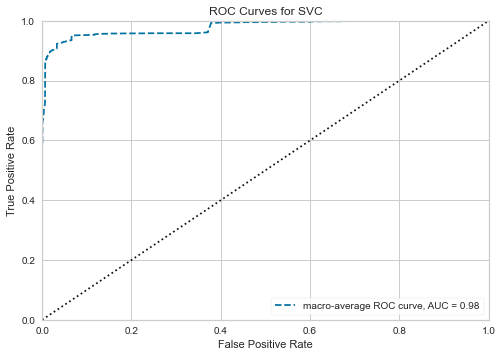

====================SVC(C=10, gamma=1, kernel='sigmoid')ConfusionMatrix====================


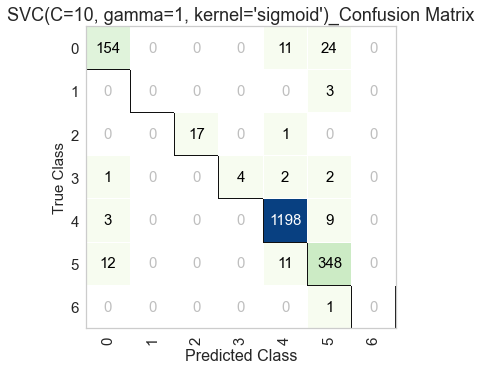

====================LinearSVC(C=1000, max_iter=500)ROCAUC====================


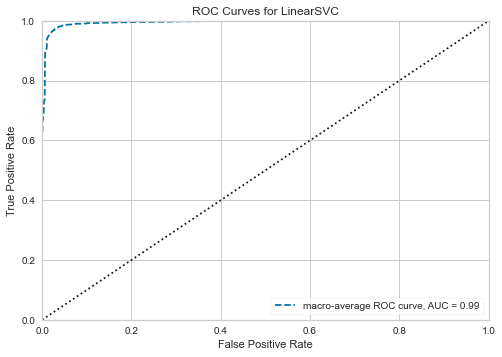

====================LinearSVC(C=1000, max_iter=500)ConfusionMatrix====================


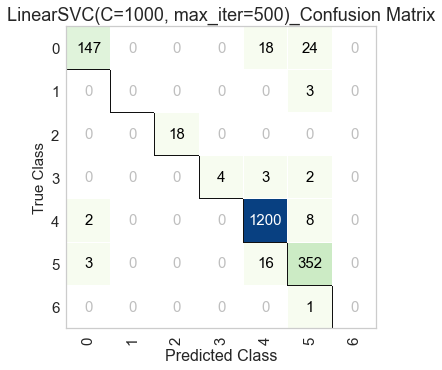

====================RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True)ROCAUC====================


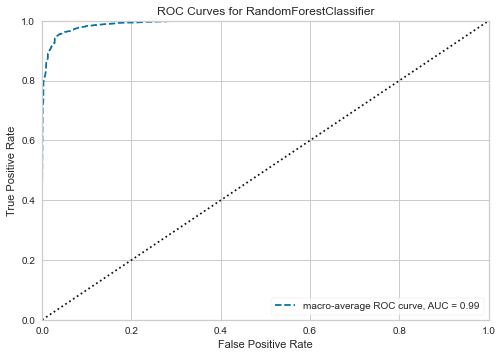

====================RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True)ConfusionMatrix====================


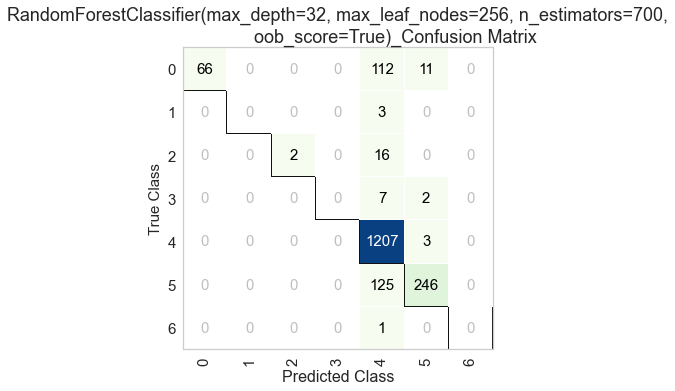

====================KNeighborsClassifier(leaf_size=1, weights='distance')ROCAUC====================


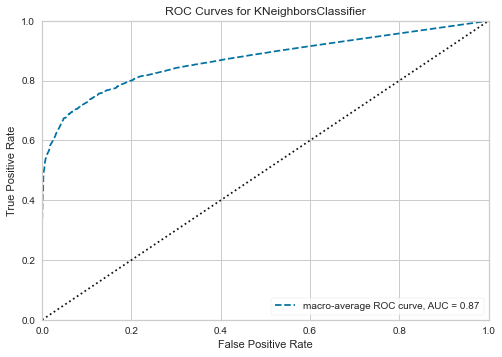

====================KNeighborsClassifier(leaf_size=1, weights='distance')ConfusionMatrix====================


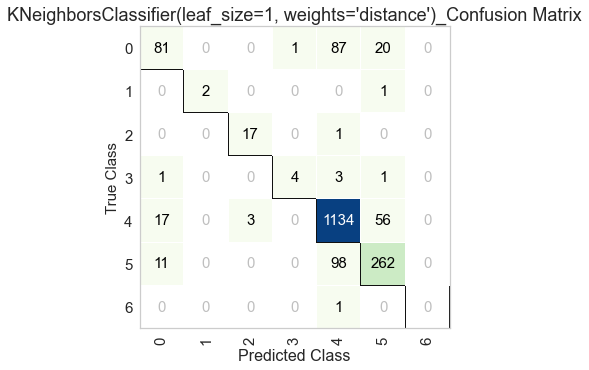

====================MultinomialNB(alpha=0.03)ROCAUC====================


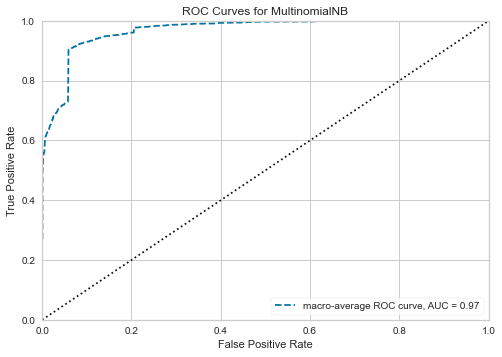

====================MultinomialNB(alpha=0.03)ConfusionMatrix====================


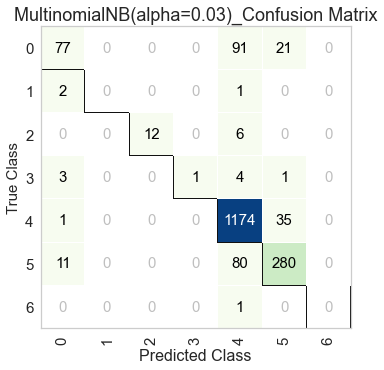

In [49]:
models=[svc_clf, lisvc_clf, rf_clf, knn_clf, mod_clf]

for model in tqdm_notebook(models):
    print('====================%sROCAUC===================='%model)
    visualizer = ROCAUC(model, classes=[0,1,2,3,4,5,6], micro=False, macro=True, per_class=False)
    visualizer.fit(X_train_tfidf, y_train)
    visualizer.score(X_test_tfidf, y_test)
    visualizer.show()
    
    print('====================%sConfusionMatrix===================='%model)

    plt.figure()
    plt.title("%s_Confusion Matrix"%model, fontsize=18)
    plt.xlabel("Predicted Class", fontsize=16)
    plt.ylabel("True Class", fontsize=15)

    cm = ConfusionMatrix(model, classes=[0,1,2,3,4,5,6], size=(400,400),fontsize=15, cmap='GnBu')
    cm.fit(X_train_tfidf, y_train)
    cm.score(X_test_tfidf, y_test)
    plt.show()

In [11]:
from sklearn.metrics import recall_score , precision_score , f1_score , accuracy_score,classification_report

In [73]:
acc=[]
pre=[]
rec=[]
f=[]

for model in models:
    print('==========',model,'==========')
    model.fit(X_train_tfidf, y_train)
    pred=model.predict(X_test_tfidf)
    accuracy=accuracy_score(pred, y_test)
    precison = precision_score(pred, y_test, average='weighted')
    recall = precision_score(pred, y_test, average='weighted')
    f1 = f1_score(pred, y_test, average='weighted')
    print("accuracy:", accuracy)
    print("precison:", precison)
    print("recall:", recall)
    print("f1:", f1)
    acc.append(accuracy)
    pre.append(precison)
    rec.append(recall)
    f.append(f1)
    print('추가 완료')
    print('classification report')
    print(classification_report(y_test, pred))
    print('===========================')

========== SVC(C=10, gamma=1, kernel='sigmoid') ==========
accuracy: 0.9555802332037757
precison: 0.9607057259774494
recall: 0.9607057259774494
f1: 0.9575636888556922
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       189
           1       0.00      0.00      0.00         3
           2       1.00      0.94      0.97        18
           3       1.00      0.44      0.62         9
           4       0.98      0.99      0.98      1210
           5       0.90      0.94      0.92       371
           6       0.00      0.00      0.00         1

    accuracy                           0.96      1801
   macro avg       0.68      0.59      0.62      1801
weighted avg       0.95      0.96      0.95      1801

========== LinearSVC(C=1000, max_iter=500) ==========


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy: 0.9555802332037757
precison: 0.9632447605119544
recall: 0.9632447605119544
f1: 0.9581013498076363
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       189
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00        18
           3       1.00      0.44      0.62         9
           4       0.97      0.99      0.98      1210
           5       0.90      0.95      0.93       371
           6       0.00      0.00      0.00         1

    accuracy                           0.96      1801
   macro avg       0.69      0.59      0.63      1801
weighted avg       0.95      0.96      0.95      1801

========== RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True) ==========
accuracy: 0.8484175458078845
precison: 0.9243568190948293
recall: 0.9243568190948293
f1: 0.8698923289156432
추가 완료
classification re

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.832870627429206
precison: 0.8609299209996554
recall: 0.8609299209996554
f1: 0.8426117540778515
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.74      0.43      0.54       189
           1       1.00      0.67      0.80         3
           2       0.85      0.94      0.89        18
           3       0.80      0.44      0.57         9
           4       0.86      0.94      0.90      1210
           5       0.77      0.71      0.74       371
           6       0.00      0.00      0.00         1

    accuracy                           0.83      1801
   macro avg       0.72      0.59      0.63      1801
weighted avg       0.83      0.83      0.82      1801

========== MultinomialNB(alpha=0.03) ==========
accuracy: 0.8573014991671294
precison: 0.8980419080121648
recall: 0.8980419080121648
f1: 0.8710355727373499
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.82      

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
#######결과#########
col_name=['accuracy','precision','recall','f1']
index_name=['SVC(sigmoid)','LinearSVC','RandomForest', 'KNN','NaiveBayes']
score_df=pd.DataFrame({col_name[0]:acc,
                      col_name[1]:pre,
                      col_name[2]:rec,
                      col_name[3]:f},
                     index=index_name)

In [75]:
score_df

,accuracy,precision,recall,f1
SVC(sigmoid),0.955580,0.960706,0.960706,0.957564
LinearSVC,0.955580,0.963245,0.963245,0.958101
RandomForest,0.848418,0.924357,0.924357,0.869892
KNN,0.832871,0.860930,0.860930,0.842612
NaiveBayes,0.857301,0.898042,0.898042,0.871036


In [76]:
#엑셀파일 저장
writer = pd.ExcelWriter('./project_data/model/최종_5개알고리즘_score.xlsx', engine='xlsxwriter')  #경로 각자에 맞게 변경
score_df.to_excel(writer)
writer.save()

# 최종모델저장

In [50]:
comp_word=company['okt_han_kkma'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [51]:
#company['okt_han_kkma'] 벡터화
temp =company['okt_han_kkma'].tolist()
X_tfidf = tfidf.transform(temp)
print(X_tfidf.shape)

y=company['category']

(7202, 52071)


In [52]:
svc_model= SVC(kernel='sigmoid', C=10, gamma=1,  probability=True)
svc_model.fit(X_tfidf, y)

SVC(C=10, gamma=1, kernel='sigmoid', probability=True)

In [53]:
joblib.dump(svc_model,'./project_data/final_data/svc_model_0224.pkl') #final_data로 이동

['./project_data/final_data/svc_model_0224.pkl']

In [54]:
lisvc_model= LinearSVC(C=1000,max_iter=500, penalty='l2')
lisvc_model.fit(X_tfidf, y)

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1000, max_iter=500)

In [55]:
joblib.dump(lisvc_model,'./project_data/final_data/lisvc_model_0224.pkl')

['./project_data/final_data/lisvc_model_0224.pkl']

random_state다르게 해서 svc, linearsvc 비교하기

In [63]:
X_train, X_test, y_train, y_test = train_test_split(company['okt_han_kkma'], company.category,\
                                                    shuffle=True,\
                                                    stratify = company.category)


#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['okt_han_kkma'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [64]:
temp =X_train.tolist()
X_train_tfidf = tfidf.transform(temp)
print(X_train_tfidf.shape)

#X_test 벡터화
temp =X_test.tolist()
X_test_tfidf = tfidf.transform(temp)
print(X_test_tfidf.shape)

(5401, 42869)
(1801, 42869)


In [65]:
svc_clf=SVC(kernel='sigmoid', C=10, gamma=1)
lisvc_clf=LinearSVC(C=1000,max_iter=500, penalty='l2')

랜덤 1차

In [62]:
acc=[]
pre=[]
rec=[]
f=[]

for model in models:
    print('==========',model,'==========')
    model.fit(X_train_tfidf, y_train)
    pred=model.predict(X_test_tfidf)
    accuracy=accuracy_score(pred, y_test)
    precison = precision_score(pred, y_test, average='weighted')
    recall = precision_score(pred, y_test, average='weighted')
    f1 = f1_score(pred, y_test, average='weighted')
    print("accuracy:", accuracy)
    print("precison:", precison)
    print("recall:", recall)
    print("f1:", f1)
    acc.append(accuracy)
    pre.append(precison)
    rec.append(recall)
    f.append(f1)
    print('추가 완료')
    print('classification report')
    print(classification_report(y_test, pred))
    print('===========================')

========== SVC(C=10, gamma=1, kernel='sigmoid') ==========
accuracy: 0.9511382565241533
precison: 0.959566223893837
recall: 0.959566223893837
f1: 0.9547427558021017
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       189
           1       0.00      0.00      0.00         3
           2       1.00      0.94      0.97        18
           3       1.00      0.11      0.20         9
           4       0.97      0.99      0.98      1210
           5       0.92      0.93      0.93       371
           6       0.00      0.00      0.00         1

    accuracy                           0.95      1801
   macro avg       0.68      0.54      0.56      1801
weighted avg       0.95      0.95      0.95      1801

========== LinearSVC(C=1000, max_iter=500) ==========


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy: 0.9483620210993893
precison: 0.9578774165058895
recall: 0.9578774165058895
f1: 0.9515513545232255
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       189
           1       1.00      0.33      0.50         3
           2       1.00      0.94      0.97        18
           3       1.00      0.22      0.36         9
           4       0.96      0.99      0.98      1210
           5       0.90      0.93      0.92       371
           6       0.00      0.00      0.00         1

    accuracy                           0.95      1801
   macro avg       0.83      0.60      0.65      1801
weighted avg       0.95      0.95      0.95      1801

========== RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True) ==========
accuracy: 0.8345363686840644
precison: 0.9207791568280262
recall: 0.9207791568280262
f1: 0.8581696449568895
추가 완료
classification re

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.8212104386451972
precison: 0.851522316476892
recall: 0.851522316476892
f1: 0.8318441909437516
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.72      0.43      0.54       189
           1       1.00      0.67      0.80         3
           2       0.77      0.94      0.85        18
           3       1.00      0.22      0.36         9
           4       0.85      0.93      0.89      1210
           5       0.74      0.67      0.70       371
           6       0.00      0.00      0.00         1

    accuracy                           0.82      1801
   macro avg       0.73      0.55      0.59      1801
weighted avg       0.81      0.82      0.81      1801

========== MultinomialNB(alpha=0.03) ==========
accuracy: 0.8478622987229317
precison: 0.8908879774863319
recall: 0.8908879774863319
f1: 0.8620902797719507
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.85      0

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2차

In [66]:
acc=[]
pre=[]
rec=[]
f=[]

for model in models:
    print('==========',model,'==========')
    model.fit(X_train_tfidf, y_train)
    pred=model.predict(X_test_tfidf)
    accuracy=accuracy_score(pred, y_test)
    precison = precision_score(pred, y_test, average='weighted')
    recall = precision_score(pred, y_test, average='weighted')
    f1 = f1_score(pred, y_test, average='weighted')
    print("accuracy:", accuracy)
    print("precison:", precison)
    print("recall:", recall)
    print("f1:", f1)
    acc.append(accuracy)
    pre.append(precison)
    rec.append(recall)
    f.append(f1)
    print('추가 완료')
    print('classification report')
    print(classification_report(y_test, pred))
    print('===========================')

========== SVC(C=10, gamma=1, kernel='sigmoid') ==========
accuracy: 0.943364797334814
precison: 0.9518216516331723
recall: 0.9518216516331723
f1: 0.946546373562149
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       189
           1       0.00      0.00      0.00         3
           2       1.00      0.83      0.91        18
           3       1.00      0.33      0.50         9
           4       0.96      0.99      0.98      1210
           5       0.91      0.90      0.91       371
           6       0.00      0.00      0.00         1

    accuracy                           0.94      1801
   macro avg       0.68      0.55      0.59      1801
weighted avg       0.94      0.94      0.94      1801

========== LinearSVC(C=1000, max_iter=500) ==========


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy: 0.9428095502498612
precison: 0.9516063500415629
recall: 0.9516063500415629
f1: 0.9459725447799436
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       189
           1       0.00      0.00      0.00         3
           2       0.94      0.83      0.88        18
           3       1.00      0.44      0.62         9
           4       0.96      0.99      0.97      1210
           5       0.91      0.91      0.91       371
           6       0.00      0.00      0.00         1

    accuracy                           0.94      1801
   macro avg       0.67      0.56      0.60      1801
weighted avg       0.94      0.94      0.94      1801

========== RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True) ==========
accuracy: 0.8411993337034981
precison: 0.9292191336914919
recall: 0.9292191336914919
f1: 0.8667183421333082
추가 완료
classification re

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.8206551915602444
precison: 0.8456820753299839
recall: 0.8456820753299839
f1: 0.8297314841505286
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.69      0.43      0.53       189
           1       0.00      0.00      0.00         3
           2       0.93      0.72      0.81        18
           3       1.00      0.67      0.80         9
           4       0.85      0.92      0.88      1210
           5       0.75      0.70      0.73       371
           6       0.00      0.00      0.00         1

    accuracy                           0.82      1801
   macro avg       0.60      0.49      0.54      1801
weighted avg       0.81      0.82      0.81      1801

========== MultinomialNB(alpha=0.03) ==========
accuracy: 0.8478622987229317
precison: 0.8880214334462643
recall: 0.8880214334462643
f1: 0.8617054978470117
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.79     

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


결론)SVC선택

2/25모델재생성

In [16]:
X_train, X_test, y_train, y_test = train_test_split(company['okt_han_kkma'], company.category,\
                                                    shuffle=True, random_state=1, \
                                                    stratify = company.category)


#comp_word=company['all_word'].tolist()
X_train_pd=pd.DataFrame(X_train)
comp_word=X_train_pd['okt_han_kkma'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [17]:
#X_train 벡터화
temp =X_train.tolist()
X_train_tfidf = tfidf.transform(temp)
print(X_train_tfidf.shape)

#X_test 벡터화
temp =X_test.tolist()
X_test_tfidf = tfidf.transform(temp)
print(X_test_tfidf.shape)

(5401, 42632)
(1801, 42632)


In [18]:
models=[svc_clf, lisvc_clf]


acc=[]
pre=[]
rec=[]
f=[]

for model in models:
    print('==========',model,'==========')
    model.fit(X_train_tfidf, y_train)
    pred=model.predict(X_test_tfidf)
    accuracy=accuracy_score(pred, y_test)
    precison = precision_score(pred, y_test, average='weighted')
    recall = precision_score(pred, y_test, average='weighted')
    f1 = f1_score(pred, y_test, average='weighted')
    print("accuracy:", accuracy)
    print("precison:", precison)
    print("recall:", recall)
    print("f1:", f1)
    acc.append(accuracy)
    pre.append(precison)
    rec.append(recall)
    f.append(f1)
    print('추가 완료')
    print('classification report')
    print(classification_report(y_test, pred))
    print('===========================')

========== SVC(C=10, gamma=1, kernel='sigmoid') ==========
accuracy: 0.9555802332037757
precison: 0.9607057259774494
recall: 0.9607057259774494
f1: 0.9575636888556922
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       189
           1       0.00      0.00      0.00         3
           2       1.00      0.94      0.97        18
           3       1.00      0.44      0.62         9
           4       0.98      0.99      0.98      1210
           5       0.90      0.94      0.92       371
           6       0.00      0.00      0.00         1

    accuracy                           0.96      1801
   macro avg       0.68      0.59      0.62      1801
weighted avg       0.95      0.96      0.95      1801

========== LinearSVC(C=1000, max_iter=500) ==========


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.9555802332037757
precison: 0.9632447605119544
recall: 0.9632447605119544
f1: 0.9581013498076363
추가 완료
classification report
              precision    recall  f1-score   support

           0       0.97      0.78      0.86       189
           1       0.00      0.00      0.00         3
           2       1.00      1.00      1.00        18
           3       1.00      0.44      0.62         9
           4       0.97      0.99      0.98      1210
           5       0.90      0.95      0.93       371
           6       0.00      0.00      0.00         1

    accuracy                           0.96      1801
   macro avg       0.69      0.59      0.63      1801
weighted avg       0.95      0.96      0.95      1801



C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [19]:
#######결과#########
col_name=['accuracy','precision','recall','f1']
index_name=['SVC(sigmoid)','LinearSVC']
score_df=pd.DataFrame({col_name[0]:acc,
                      col_name[1]:pre,
                      col_name[2]:rec,
                      col_name[3]:f},
                     index=index_name)

In [20]:
score_df

,accuracy,precision,recall,f1
SVC(sigmoid),0.95558,0.960706,0.960706,0.957564
LinearSVC,0.95558,0.963245,0.963245,0.958101


<ipython-input-21-750295bfe965>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model in tqdm_notebook(models):


====================SVC(C=10, gamma=1, kernel='sigmoid')ROCAUC====================


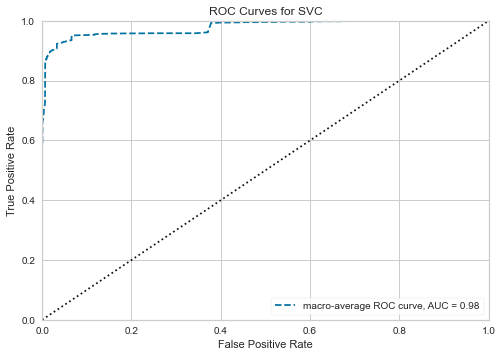

====================SVC(C=10, gamma=1, kernel='sigmoid')ConfusionMatrix====================


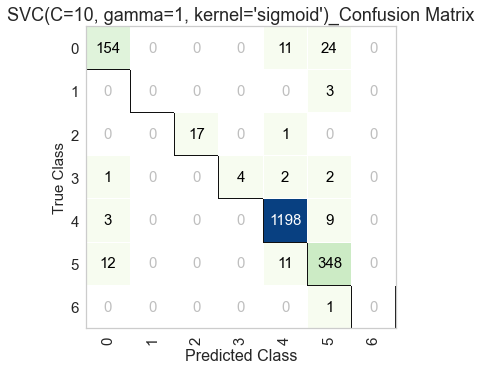

====================LinearSVC(C=1000, max_iter=500)ROCAUC====================


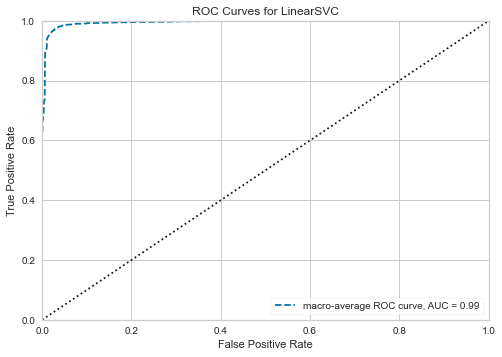

====================LinearSVC(C=1000, max_iter=500)ConfusionMatrix====================


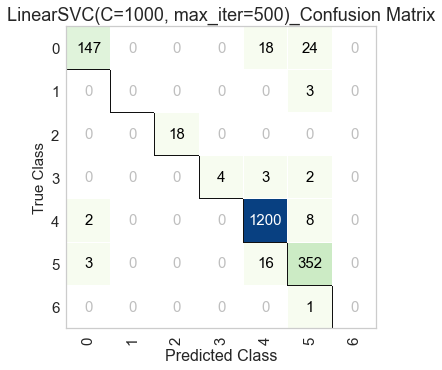

====================RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True)ROCAUC====================


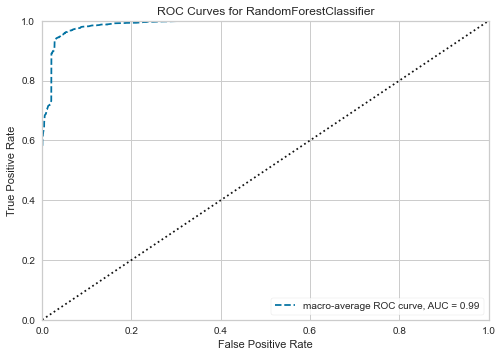

====================RandomForestClassifier(max_depth=32, max_leaf_nodes=256, n_estimators=700,
                       oob_score=True)ConfusionMatrix====================


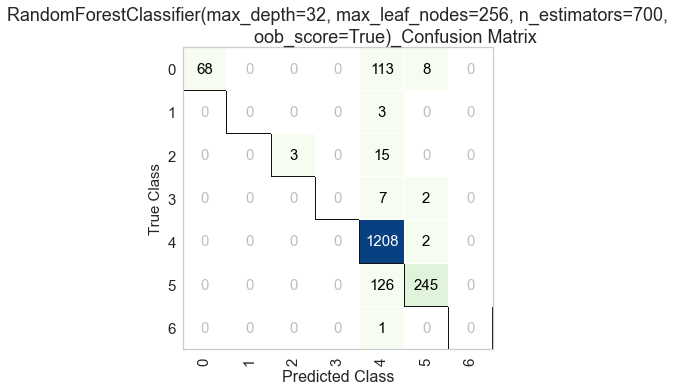

In [21]:
models=[svc_clf, lisvc_clf, rf_clf]

for model in tqdm_notebook(models):
    print('====================%sROCAUC===================='%model)
    visualizer = ROCAUC(model, classes=[0,1,2,3,4,5,6], micro=False, macro=True, per_class=False)
    visualizer.fit(X_train_tfidf, y_train)
    visualizer.score(X_test_tfidf, y_test)
    visualizer.show()
    
    print('====================%sConfusionMatrix===================='%model)

    plt.figure()
    plt.title("%s_Confusion Matrix"%model, fontsize=18)
    plt.xlabel("Predicted Class", fontsize=16)
    plt.ylabel("True Class", fontsize=15)

    cm = ConfusionMatrix(model, classes=[0,1,2,3,4,5,6], size=(400,400),fontsize=15, cmap='GnBu')
    cm.fit(X_train_tfidf, y_train)
    cm.score(X_test_tfidf, y_test)
    plt.show()

In [25]:
comp_word=company['okt_han_kkma'].tolist()
sup_word=support['all_word_new'].tolist()
word_list=list(set(comp_word+sup_word))

tfidf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df =5, sublinear_tf = True)
tfidf.fit(word_list)

TfidfVectorizer(min_df=5, ngram_range=(1, 2), sublinear_tf=True)

In [26]:
#company['okt_han_kkma'] 벡터화
temp =company['okt_han_kkma'].tolist()
X_tfidf = tfidf.transform(temp)
print(X_tfidf.shape)

y=company['category']

(7202, 52071)


In [27]:
lisvc_model= LinearSVC(C=1000,max_iter=500, penalty='l2')
lisvc_model.fit(X_tfidf, y)

C:\Users\user\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1000, max_iter=500)

In [28]:
joblib.dump(lisvc_model,'./final_data/lisvc_model_0225.pkl')

['./final_data/lisvc_model_0225.pkl']